# **Project :** Evaluating Solutions to Ameliorate the Impact of Food Deserts in Brooklyn Using AI

## **Problem Statement :** Develop a Machine Learning model to classify food desert and non-food desert areas in Brooklyn (Kings County, New York)

## **1. Import Libraries**

In [1]:
#=================================================================
# For data manipulation, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import calendar
from datetime import datetime

import pickle 
#===============================================================================================
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow.math import confusion_matrix
#=================================================================
# From sklearn import required classes
#=================================================================
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz 
from IPython.display import display, Image
from graphviz import Source
from sklearn import tree

## **2. Load the Dataset and Perform Visualization**

### **2.1. Load the Dataset**

**Data Source :** https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis/tree/main

In [2]:
#!git clone https://github.com/omdena-chapter-brooklyn-food-desert/Data-Collection-and-Analysis.git

In [3]:
df_preprocess = pd.read_csv('KingCounty_FoodDeserts_StdzdData_Clusters.csv')
df_preprocess.head(3)

,Unnamed: 0,STATEFP_x,COUNTYFP_x,TRACTCE,CensusTract,State,County,Urban,Pop2010,OHU2010,...,COUNTYFP_y,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,SNAP,TargetLabel
0,0,36,47,57800,36047057800,New York,Kings County,1,3176,1077,...,47.0,1400000US36047057800,3.604706e+10,578.0,CT,172233.0,0.0,POLYGON ((-73.95397799999999 40.60140099999999...,0.276615,1
1,1,36,47,37000,36047037000,New York,Kings County,1,4085,1566,...,47.0,1400000US36047037000,3.604704e+10,370.0,CT,336242.0,0.0,"POLYGON ((-73.96615 40.586669, -73.96564099999...",0.178423,4
2,2,36,47,19900,36047019900,New York,Kings County,1,2929,1476,...,47.0,1400000US36047019900,3.604702e+10,199.0,CT,188914.0,0.0,"POLYGON ((-73.96949 40.686288, -73.96749299999...",0.049125,0


In [4]:
df_preprocess.shape

(698, 330)

In [5]:
df_preprocess.columns

Index(['Unnamed: 0', 'STATEFP_x', 'COUNTYFP_x', 'TRACTCE', 'CensusTract',
       'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       ...
       'COUNTYFP_y', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry', 'SNAP', 'TargetLabel'],
      dtype='object', length=330)

In [6]:
features_req = ['DISADVANTAGE16_20', 'MEDFAMINC16_20', 'SNAP', 'PovertyRate',
                'TractKids','TractSeniors','TractWhite','TractBlack','TractAsian','TractNHOPI',
                'TractAIAN', 'TractOMultir','TractHispanic','TractHUNV', 'TractSNAP','TargetLabel']

### **2.2. Store Required Features in DF**

In [7]:
# copy required features
df = df_preprocess.loc[:, features_req]
df.head(3)

,DISADVANTAGE16_20,MEDFAMINC16_20,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,708,418,1951,33,861,0,6,325,390,512,278,1
1,0.214406,87813,0.178423,15.6,802,623,3017,17,804,0,23,224,242,396,178,4
2,0.079001,161250,0.049125,12.4,370,294,1227,1348,117,0,5,232,327,1036,183,0


In [8]:
df.rename(columns= {'DISADVANTAGE16_20':'Disadvantage', 'MEDFAMINC16_20':'Medfamilyincome'}, inplace=True)

In [9]:
df.head(3)

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,TargetLabel
0,0.253815,87500,0.276615,21.6,708,418,1951,33,861,0,6,325,390,512,278,1
1,0.214406,87813,0.178423,15.6,802,623,3017,17,804,0,23,224,242,396,178,4
2,0.079001,161250,0.049125,12.4,370,294,1227,1348,117,0,5,232,327,1036,183,0


In [10]:
df.shape

(698, 16)

In [11]:
n_labels=df['TargetLabel'].nunique()
n_labels

5

## **3. Exploratory Data Aanalysis (EDA)**

**Features Description:**

* Disadvantage = mean of pfaminclt40k16_20, ppov16_20, and ppubas16_20
    * pfaminclt40k16_20 : Proportion of families with income less than $40,000
    * ppov16_20 : Proportion people w/ income in the past 12 months below poverty level
    * ppubas16_20 : Proportion of households with public assistance income or food stamps
     

* Medfamilyincome = Tract median family income
* SNAP = Proportion of households with public assistance income or food stamps
* PovertyRate = Poverty Rate'
* TractKids = Total count of children age 0-17 in tract
* TractSeniors = Total count of seniors age 65+ in tract
* TractWhite = Total count of White population in tract
* TractBlack = Total count of Black or African American population in tract    
* TractAsian = Total count of Asian population in tract'
* TractNHOPI = Total count of Native Hawaiian and Other Pacific Islander population in tract
* TractAIAN = Total count of American Indian and Alaska Native population in tract
* TractOMultir = Total count of Other/Multiple race population in tract
* TractHispanic = Total count of Hispanic or Latino population in tract
* TractHUNV = Total count of housing units without a vehicle in tract
* TractSNAP = Total count of housing units receiving SNAP benefits in tract
   

In [12]:
df.isna().sum()

Disadvantage       0
Medfamilyincome    0
SNAP               0
PovertyRate        0
TractKids          0
TractSeniors       0
TractWhite         0
TractBlack         0
TractAsian         0
TractNHOPI         0
TractAIAN          0
TractOMultir       0
TractHispanic      0
TractHUNV          0
TractSNAP          0
TargetLabel        0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Disadvantage     698 non-null    float64
 1   Medfamilyincome  698 non-null    int64  
 2   SNAP             698 non-null    float64
 3   PovertyRate      698 non-null    float64
 4   TractKids        698 non-null    int64  
 5   TractSeniors     698 non-null    int64  
 6   TractWhite       698 non-null    int64  
 7   TractBlack       698 non-null    int64  
 8   TractAsian       698 non-null    int64  
 9   TractNHOPI       698 non-null    int64  
 10  TractAIAN        698 non-null    int64  
 11  TractOMultir     698 non-null    int64  
 12  TractHispanic    698 non-null    int64  
 13  TractHUNV        698 non-null    int64  
 14  TractSNAP        698 non-null    int64  
 15  TargetLabel      698 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 87.4 KB


### **3.1. Univariate Analysis**

<AxesSubplot: ylabel='TargetLabel'>

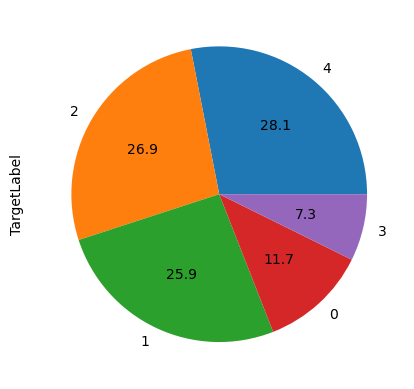

In [14]:
# Percentage of each target label 
df['TargetLabel'].value_counts().plot(kind='pie',autopct='%.1f')

**Observation : Imbalanced dataset**

<AxesSubplot: xlabel='TargetLabel', ylabel='count'>

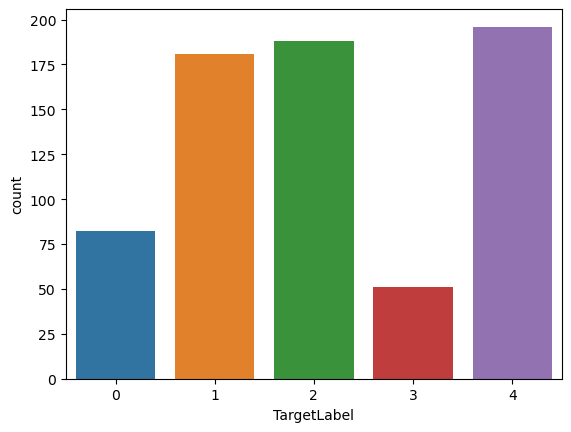

In [15]:
# Count plot
sns.countplot(data=df, x='TargetLabel')

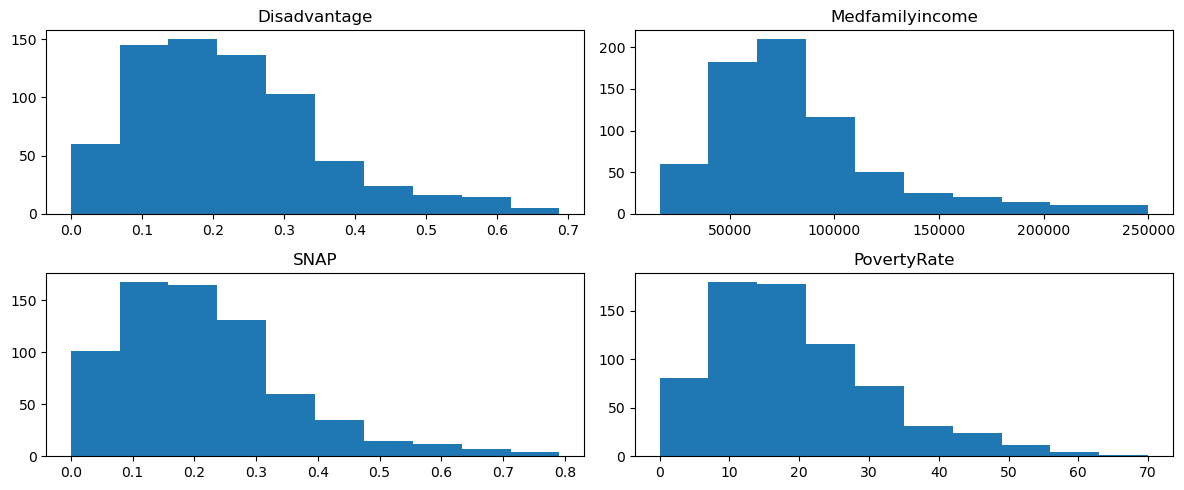

In [16]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['Disadvantage'])
ax1.set_title('Disadvantage')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['Medfamilyincome'])
ax2.set_title('Medfamilyincome')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['SNAP'])
ax3.set_title('SNAP')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(df['PovertyRate'])
ax4.set_title('PovertyRate')

plt.tight_layout()
plt.show()

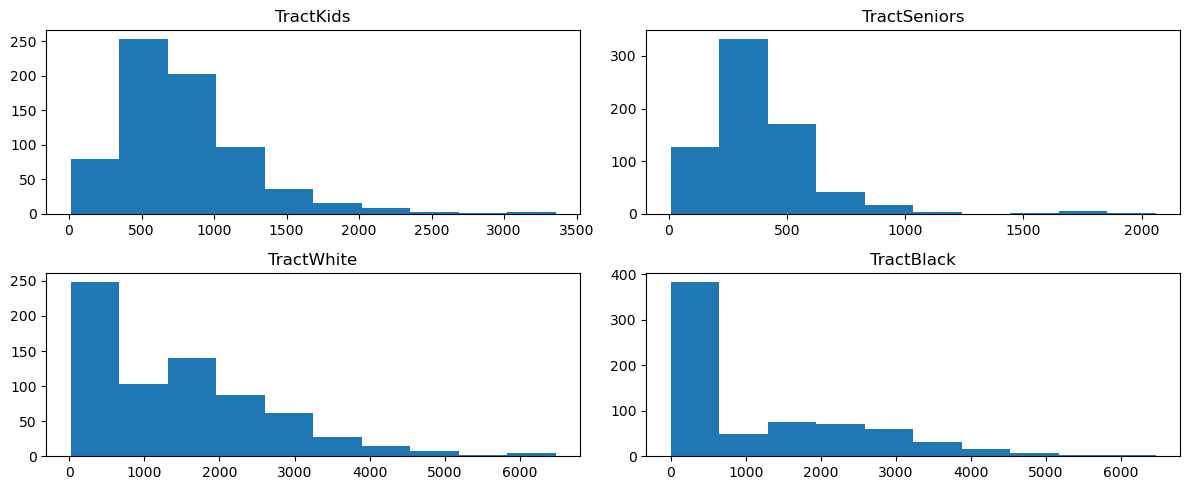

In [17]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['TractKids'])
ax1.set_title('TractKids')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['TractSeniors'])
ax2.set_title('TractSeniors')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['TractWhite'])
ax3.set_title('TractWhite')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(df['TractBlack'])
ax4.set_title('TractBlack')

plt.tight_layout()
plt.show()

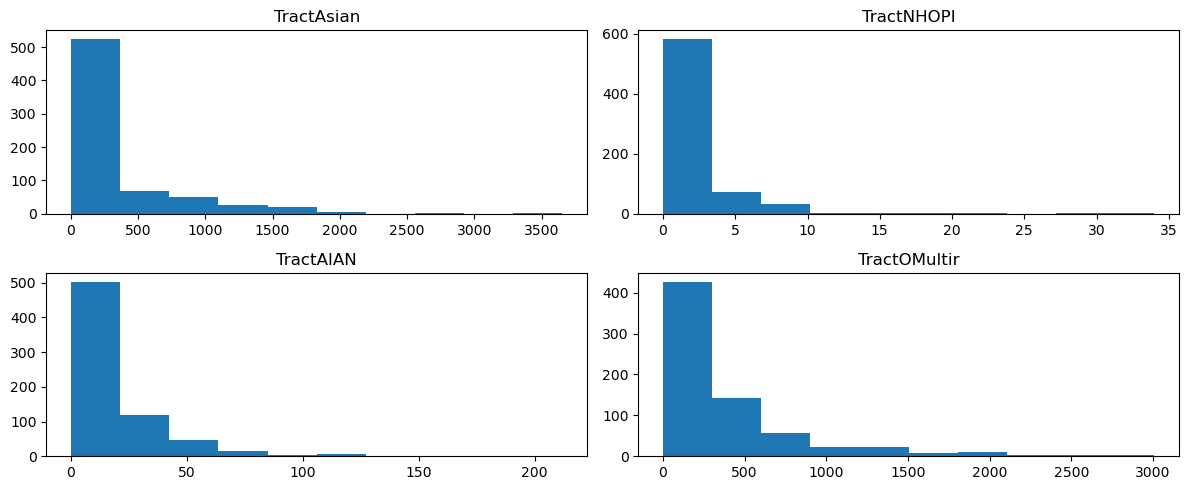

In [18]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['TractAsian'])
ax1.set_title('TractAsian')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['TractNHOPI'])
ax2.set_title('TractNHOPI')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['TractAIAN'])
ax3.set_title('TractAIAN')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(df['TractOMultir'])
ax4.set_title('TractOMultir')

plt.tight_layout()
plt.show()

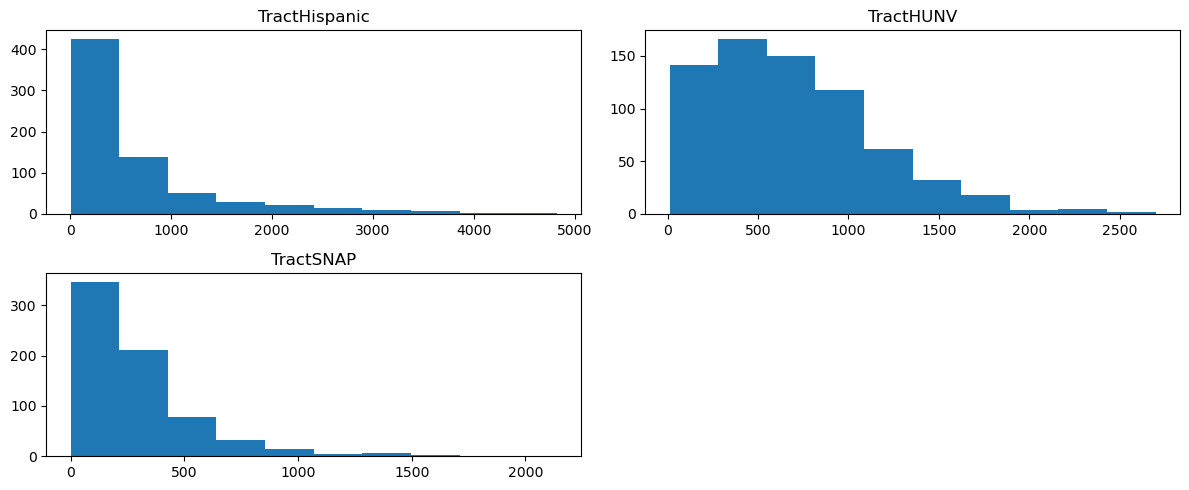

In [19]:
fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(2,2,1)
ax1.hist(df['TractHispanic'])
ax1.set_title('TractHispanic')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(df['TractHUNV'])
ax2.set_title('TractHUNV')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(df['TractSNAP'])
ax3.set_title('TractSNAP')

plt.tight_layout()
plt.show()

<AxesSubplot: >

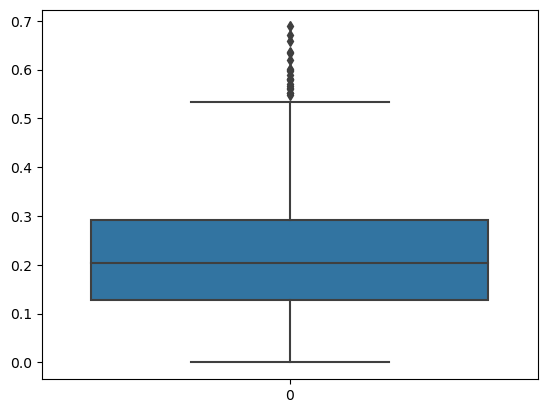

In [20]:
sns.boxplot(df['Disadvantage'])

### **3.2. Bivariate Analysis**

#### **3.2.1. Correlation matrix**

In [21]:
# create cocorrelation matrix
corr_df = df.corr().abs()
#corr_df = df.corr()
#mask = np.triu(np.ones_like(corr_df, dtype=bool))
#tri_df = corr_df.mask(mask)
#tri_df
corr_df

,Disadvantage,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,TargetLabel
Disadvantage,1.000000,0.757223,0.921736,0.870719,0.629449,0.208023,0.010820,0.231940,0.080010,0.180474,0.355568,0.345961,0.384568,0.371924,0.753653,0.107776
Medfamilyincome,0.757223,1.000000,0.677852,0.644375,0.475870,0.176552,0.157754,0.259880,0.140874,0.136601,0.302053,0.284917,0.306467,0.117276,0.537121,0.349965
SNAP,0.921736,0.677852,1.000000,0.776685,0.592573,0.256560,0.012991,0.269335,0.047493,0.163976,0.341212,0.307418,0.348195,0.380946,0.788666,0.117036
PovertyRate,0.870719,0.644375,0.776685,1.000000,0.619018,0.100521,0.042466,0.164164,0.060032,0.172306,0.354291,0.354262,0.385649,0.341586,0.665862,0.064030
TractKids,0.629449,0.475870,0.592573,0.619018,1.000000,0.259186,0.299571,0.302050,0.116995,0.217573,0.420664,0.413681,0.428124,0.479181,0.666632,0.077154
TractSeniors,0.208023,0.176552,0.256560,0.100521,0.259186,1.000000,0.444495,0.101898,0.196976,0.020736,0.047970,0.024705,0.047887,0.459902,0.519467,0.151141
TractWhite,0.010820,0.157754,0.012991,0.042466,0.299571,0.444495,1.000000,0.606796,0.213276,0.004824,0.073991,0.018211,0.013875,0.140773,0.076222,0.004536
TractBlack,0.231940,0.259880,0.269335,0.164164,0.302050,0.101898,0.606796,1.000000,0.369214,0.076268,0.192845,0.035163,0.058475,0.455374,0.418667,0.027581
TractAsian,0.080010,0.140874,0.047493,0.060032,0.116995,0.196976,0.213276,0.369214,1.000000,0.103126,0.096655,0.169486,0.148607,0.012453,0.065327,0.148982
TractNHOPI,0.180474,0.136601,0.163976,0.172306,0.217573,0.020736,0.004824,0.076268,0.103126,1.000000,0.294491,0.341449,0.346066,0.230882,0.193719,0.001058


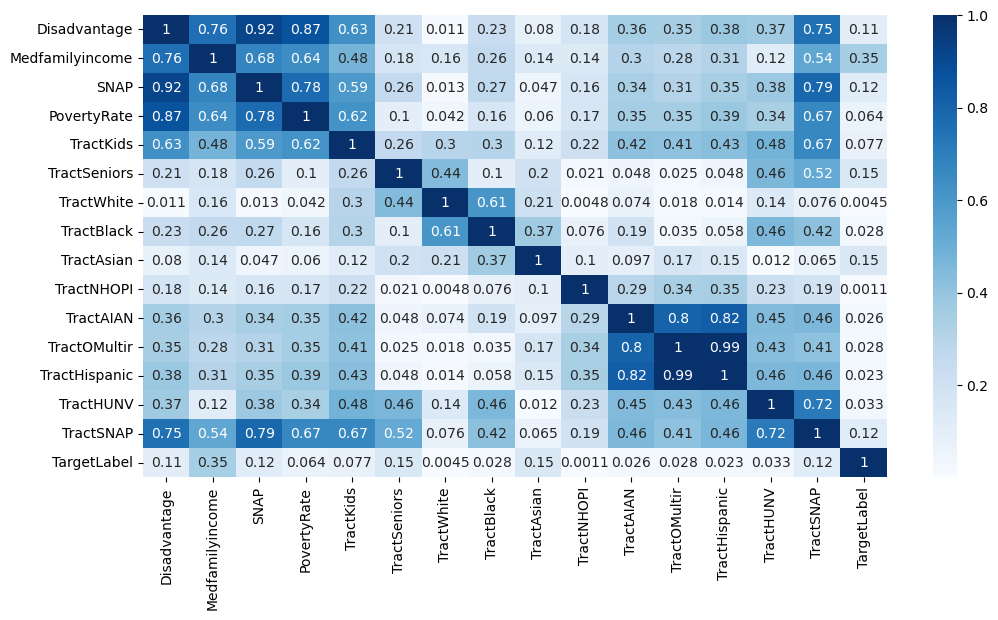

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

**Observations:**

**1) 'Disadvantage' feature is having high Correlation (0.92) with 'SNAP' feature, moreover it is dependent on 3 other variables as per NaNDA dataset hence it is dropped.**

**2) 'TractHispanic' and 'TractOMultir' have highly correlation (0.99), and TractOMultir is more generic variable for user input, hence 'TractHispanic' feature is dropped.**

In [23]:
df = df.drop(columns=['Disadvantage', 'TractHispanic'])
df.shape

(698, 14)

In [24]:
df.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHUNV,TractSNAP,TargetLabel
0,87500,0.276615,21.6,708,418,1951,33,861,0,6,325,512,278,1
1,87813,0.178423,15.6,802,623,3017,17,804,0,23,224,396,178,4
2,161250,0.049125,12.4,370,294,1227,1348,117,0,5,232,1036,183,0


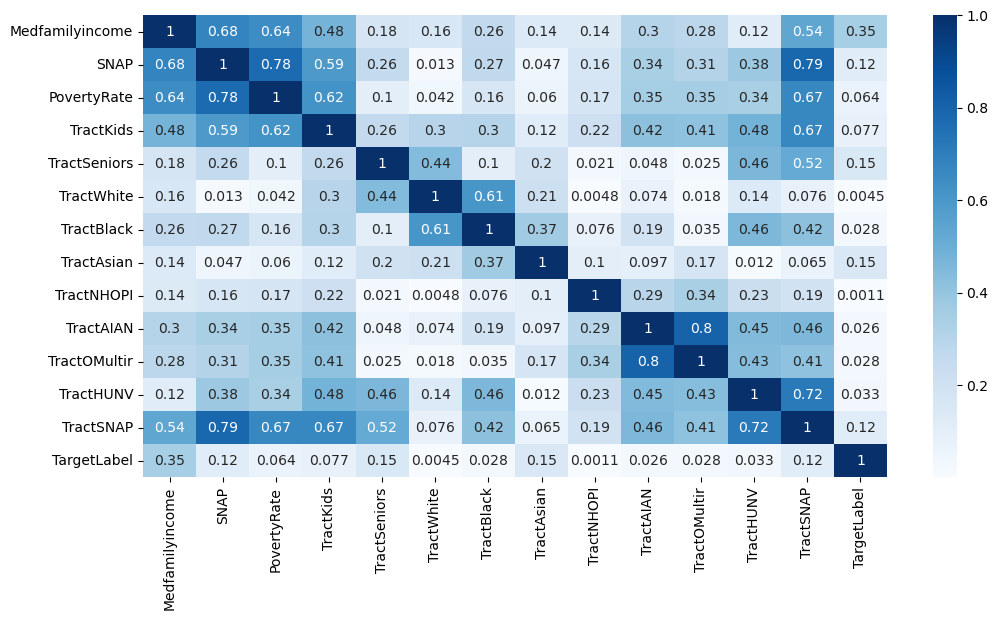

In [25]:
corr_df = df.corr().abs()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()

In [26]:
df_pairplot1 = df[['Medfamilyincome', 'SNAP', 'PovertyRate', 'TractKids', 'TargetLabel']]
df_pairplot1.head()

,Medfamilyincome,SNAP,PovertyRate,TractKids,TargetLabel
0,87500,0.276615,21.6,708,1
1,87813,0.178423,15.6,802,4
2,161250,0.049125,12.4,370,0
3,52750,0.223124,13.4,585,4
4,24956,0.475323,46.8,1331,3


In [27]:
df_pairplot2 = df[['TractSeniors', 'TractWhite', 'TractBlack', 'TargetLabel']]
df_pairplot2.head()

,TractSeniors,TractWhite,TractBlack,TargetLabel
0,418,1951,33,1
1,623,3017,17,4
2,294,1227,1348,0
3,457,1732,32,4
4,427,351,3363,3


In [28]:
df_pairplot3 = df[['TractAsian', 'TractNHOPI', 'TractAIAN', 'TargetLabel']]
df_pairplot3.head()

,TractAsian,TractNHOPI,TractAIAN,TargetLabel
0,861,0,6,1
1,804,0,23,4
2,117,0,5,0
3,942,0,8,4
4,12,3,56,3


In [29]:
df_pairplot4 = df[['TractOMultir', 'TractHUNV', 'TractSNAP', 'TargetLabel']]
df_pairplot4.head()

,TractOMultir,TractHUNV,TractSNAP,TargetLabel
0,325,512,278,1
1,224,396,178,4
2,232,1036,183,0
3,355,458,283,4
4,520,1376,756,3


#### **3.2.2. Pair Plots**

<Figure size 800x400 with 0 Axes>

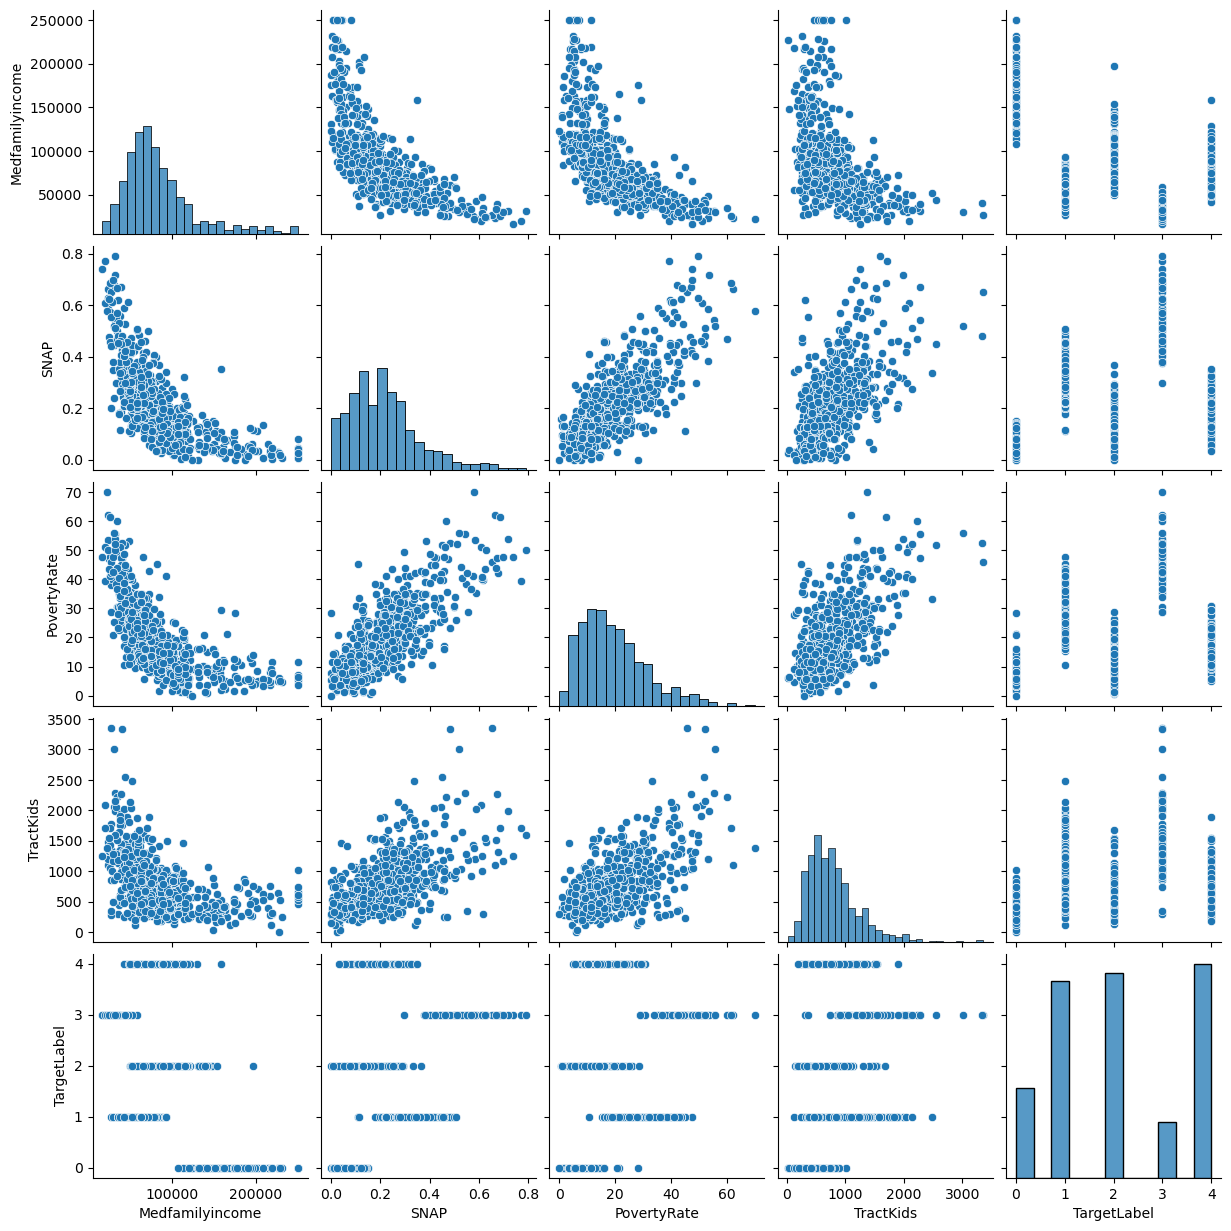

In [30]:
plt.figure(figsize=(8,4))
sns.pairplot(df_pairplot1)

<Figure size 800x400 with 0 Axes>

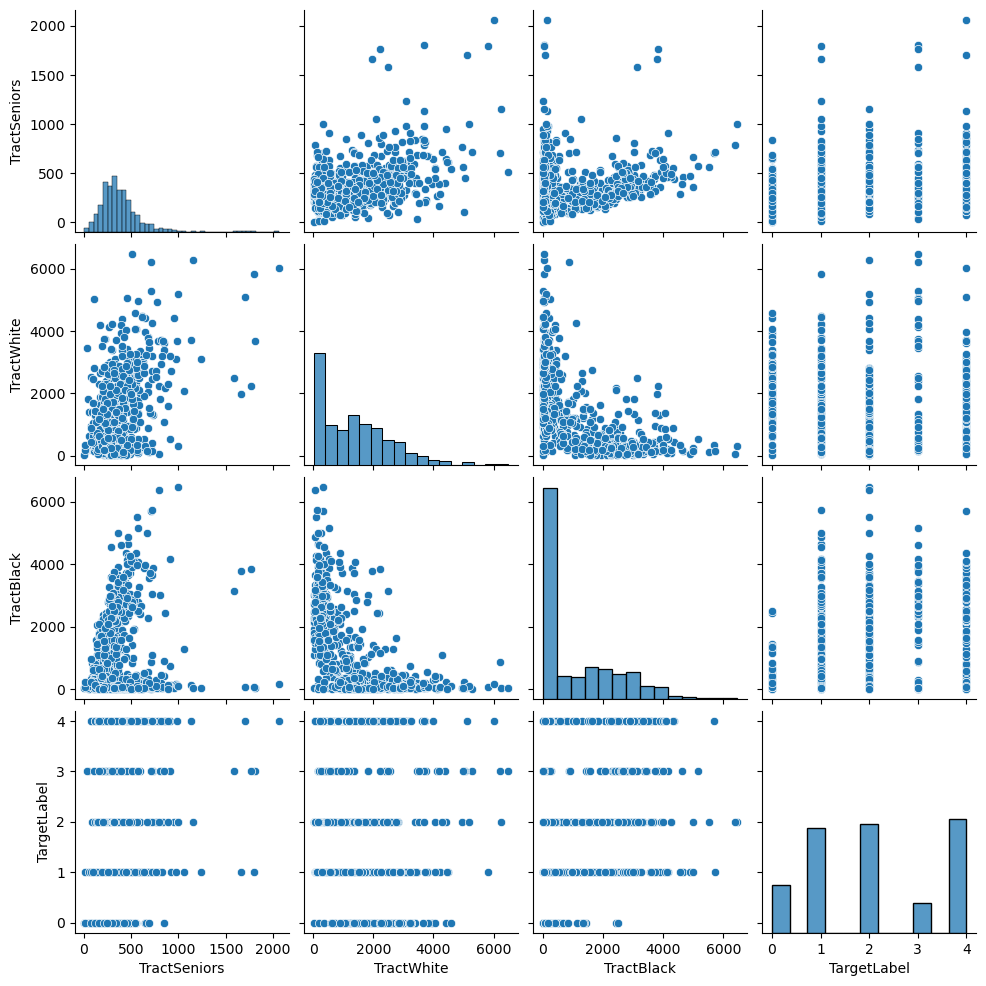

In [31]:
plt.figure(figsize=(8,4))
sns.pairplot(df_pairplot2)

<Figure size 800x400 with 0 Axes>

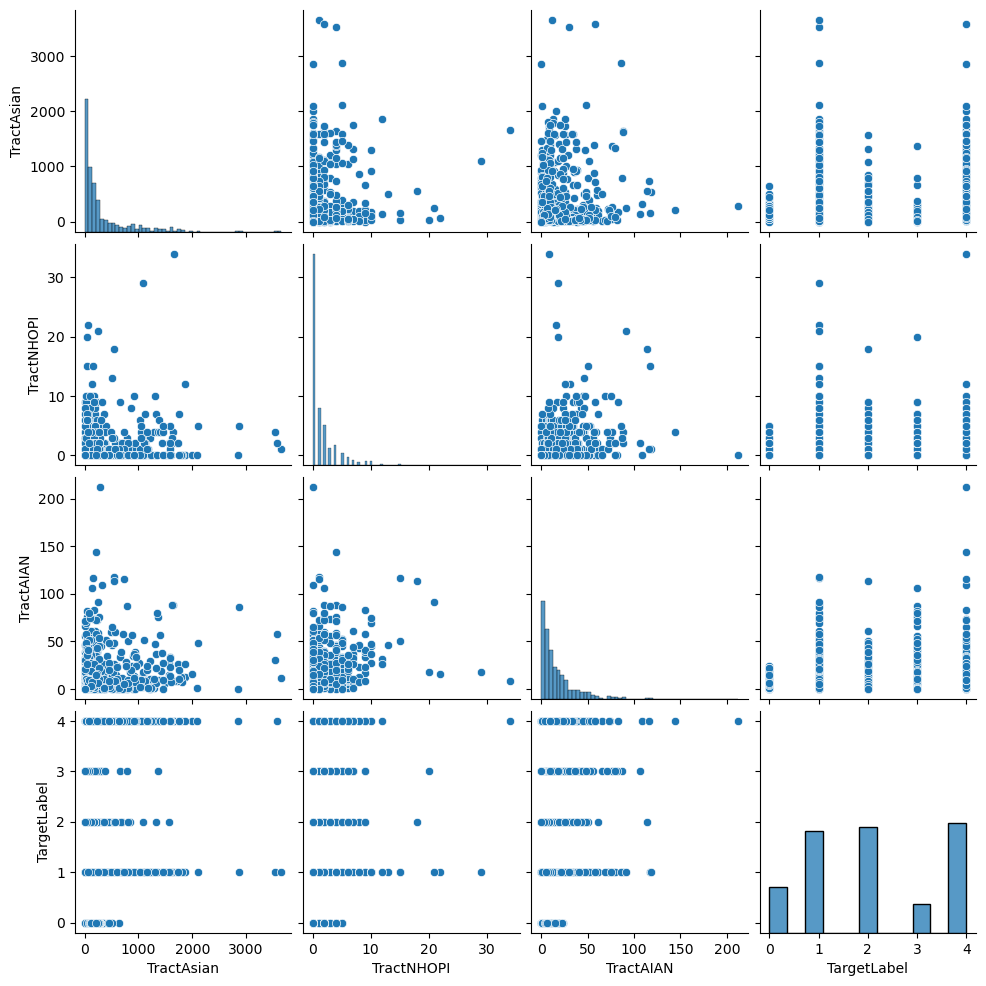

In [32]:
plt.figure(figsize=(8,4))
sns.pairplot(df_pairplot3)

<Figure size 800x400 with 0 Axes>

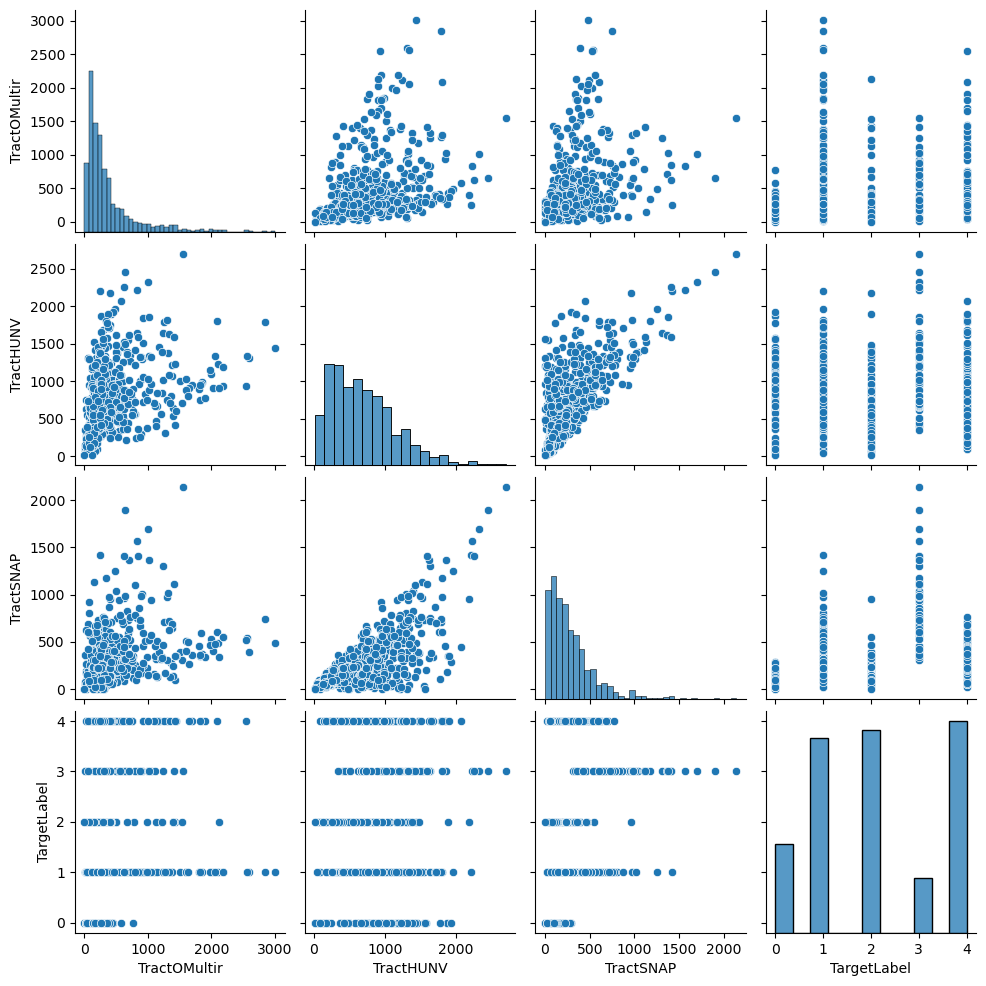

In [33]:
plt.figure(figsize=(8,4))
sns.pairplot(df_pairplot4)

In [34]:
df.to_csv('df.csv')  # saving for reference

### **3.3. Split the data into features (X) and target (y)**

In [35]:
X = df.drop(['TargetLabel'], axis=1)
y = df['TargetLabel']

In [36]:
X.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHUNV,TractSNAP
0,87500,0.276615,21.6,708,418,1951,33,861,0,6,325,512,278
1,87813,0.178423,15.6,802,623,3017,17,804,0,23,224,396,178
2,161250,0.049125,12.4,370,294,1227,1348,117,0,5,232,1036,183


In [37]:
y.head()

0    1
1    4
2    0
3    4
4    3
Name: TargetLabel, dtype: int64

In [38]:
y.value_counts()

4    196
2    188
1    181
0     82
3     51
Name: TargetLabel, dtype: int64

In [39]:
# Split the data into training and test sets
# parameter 'stratify' ensures the training and test subsets that have the same proportions of class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3, stratify = y )

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((558, 13), (140, 13), (558,), (140,))

In [41]:
X.shape, y.shape

((698, 13), (698,))

In [42]:
y_train.value_counts()

4    157
2    150
1    145
0     65
3     41
Name: TargetLabel, dtype: int64

In [43]:
y_test.value_counts()

4    39
2    38
1    36
0    17
3    10
Name: TargetLabel, dtype: int64

In [44]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data.to_csv('Train_data.csv')   # for reference

In [45]:
test_data = pd.concat([X_test,y_test], axis=1)
test_data.to_csv('Test_data.csv')    # for reference

### **3.4. Normalizing the Input data**

**Since Random Forest is a Tree-based model, hence normalization of variables is optional**

## **4. Random Forest Model**

### **4.1. Create the Model**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)








In [46]:
rfc = RandomForestClassifier(n_estimators=35, criterion='gini', max_depth=10, 
                             max_samples=0.75, max_features=0.5, oob_score=True,
                             random_state=3)
rfc.fit(X_train.values,y_train)

RandomForestClassifier(max_depth=10, max_features=0.5, max_samples=0.75,
                       n_estimators=35, oob_score=True, random_state=3)

In [47]:
train_acc = accuracy_score(y_train, rfc.predict(X_train))
test_acc = accuracy_score(y_test, rfc.predict(X_test))
print('Random Forest Training Accuracy:', round(train_acc,2))
print('Random Forest Testing Accuracy:', round(test_acc,2))  

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.82


C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [48]:
rfc.oob_score_

0.8189964157706093

### **4.2. Cross validation score**

In [49]:
np.mean(cross_val_score(RandomForestClassifier(n_estimators=35,max_samples=0.75),X_train,y_train,cv=10,scoring='accuracy'))

0.829577922077922

### **4.3. Hyper Parameter Tuning using GridSearchCV**

In [50]:
# Number of trees in random forest
n_estimators = [20,30,40,50,60,70,80,100]

# Number of features to consider at every split
max_features = [0.2,0.4,0.6,0.8,1.0]   # percentage of features

# Number of samples
max_samples = [0.5,0.75,1.0]   # percentage of samples to draw from training data to train each base estimator.

# Maximum number of levels in tree
max_depth = [6,8,10,12,None]   # None : nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


In [51]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_samples':max_samples
             }
print(param_grid)

{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 100], 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0], 'max_depth': [6, 8, 10, 12, None], 'max_samples': [0.5, 0.75, 1.0]}


In [52]:
rfc_opt = RandomForestClassifier()

In [53]:
rfc_grid = GridSearchCV(estimator = rfc_opt, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = -1)

In [54]:
rfc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, None],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [20, 30, 40, 50, 60, 70, 80, 100]},
             verbose=2)

In [55]:
rfc_grid.best_params_

{'max_depth': 10, 'max_features': 0.2, 'max_samples': 0.75, 'n_estimators': 40}

In [56]:
rfc_grid.best_score_

0.835070785070785

### **4.4. Train the Model with Optimized parameters**

In [58]:
# Set the tuned parameters

rfc = RandomForestClassifier(n_estimators=40, criterion='gini', 
                             max_depth=10,
                             max_features=0.2,
                             max_samples=0.75,
                             oob_score=True,
                             random_state=3)
# Fit the model
rfc.fit(X_train,y_train)

# Check the training and testing accuracy
train_acc = accuracy_score(y_train, rfc.predict(X_train))
test_acc = accuracy_score(y_test, rfc.predict(X_test))
print('Random Forest Training Accuracy:', round(train_acc,2))
print('Random Forest Testing Accuracy:', round(test_acc,2))  

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.82


In [59]:
rfc.oob_score_   # accuracy of the model on Out of Bag(oob) data samples (whcih can be treated as validation set)

0.8154121863799283

### **4.5. Prediction for Test dataset**

In [60]:
y_pred = rfc.predict(X_test)

In [61]:
y_pred.shape

(140,)

In [62]:
y_pred[:10]

array([4, 0, 0, 1, 4, 2, 0, 1, 1, 4], dtype=int64)

### **4.6. Confusion Matrix**

In [63]:
confusion_mat = confusion_matrix(y_test, y_pred)

In [64]:
pd.DataFrame(confusion_mat,columns=list(range(0,n_labels)))

,0,1,2,3,4
0,16,0,1,0,0
1,0,34,1,0,1
2,2,1,23,0,12
3,0,2,0,8,0
4,0,4,1,0,34


Text(0.5, 14.722222222222216, 'Predicted Labels')

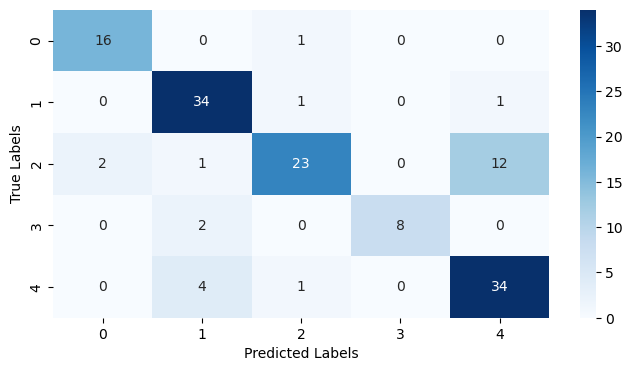

In [65]:
plt.figure(figsize=(8,4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

### **4.6. Classification Report**

In [66]:
# Print Classification Report and Accuracy score (classification accuracy)
#---------------------------------------------------------------------------
y_pred = rfc.predict(X_test)

print("-"*70)
print("Classification Report: \n", classification_report(y_test, y_pred))

print("-"*70)
print("Classification Accuracy on Test Dataset: %0.6f" % metrics.accuracy_score(y_test, y_pred))
print("-"*70)

----------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.83      0.94      0.88        36
           2       0.88      0.61      0.72        38
           3       1.00      0.80      0.89        10
           4       0.72      0.87      0.79        39

    accuracy                           0.82       140
   macro avg       0.87      0.83      0.84       140
weighted avg       0.83      0.82      0.82       140

----------------------------------------------------------------------
Classification Accuracy on Test Dataset: 0.821429
----------------------------------------------------------------------


### **4.7. Feature Importance**

In [67]:
X_train.shape

(558, 13)

In [68]:
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.

Feature_Imp = rfc.feature_importances_
Feature_Imp

array([0.15388106, 0.13652981, 0.20354031, 0.05893099, 0.03940296,
       0.0621277 , 0.05422696, 0.04439649, 0.01396199, 0.03486671,
       0.06746258, 0.0585433 , 0.07212913])

In [69]:
Feature_Imp.shape

(13,)

In [70]:
Feature_Imp = pd.Series(Feature_Imp,index=X_train.columns).sort_values(ascending=False)
Feature_Imp

PovertyRate        0.203540
Medfamilyincome    0.153881
SNAP               0.136530
TractSNAP          0.072129
TractOMultir       0.067463
TractWhite         0.062128
TractKids          0.058931
TractHUNV          0.058543
TractBlack         0.054227
TractAsian         0.044396
TractSeniors       0.039403
TractAIAN          0.034867
TractNHOPI         0.013962
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


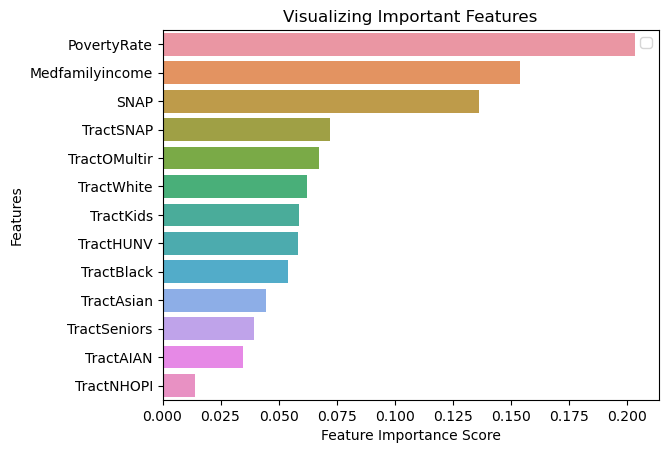

In [71]:
sns.barplot(x=Feature_Imp, y=Feature_Imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### **4.8. Visualize a Decision tree from the model**

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

sklearn.tree.export_graphviz(decision_tree, out_file=None, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, leaves_parallel=False, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=False, special_characters=False, precision=3, fontname='helvetica')

In [72]:
y_test.value_counts()

4    39
2    38
1    36
0    17
3    10
Name: TargetLabel, dtype: int64

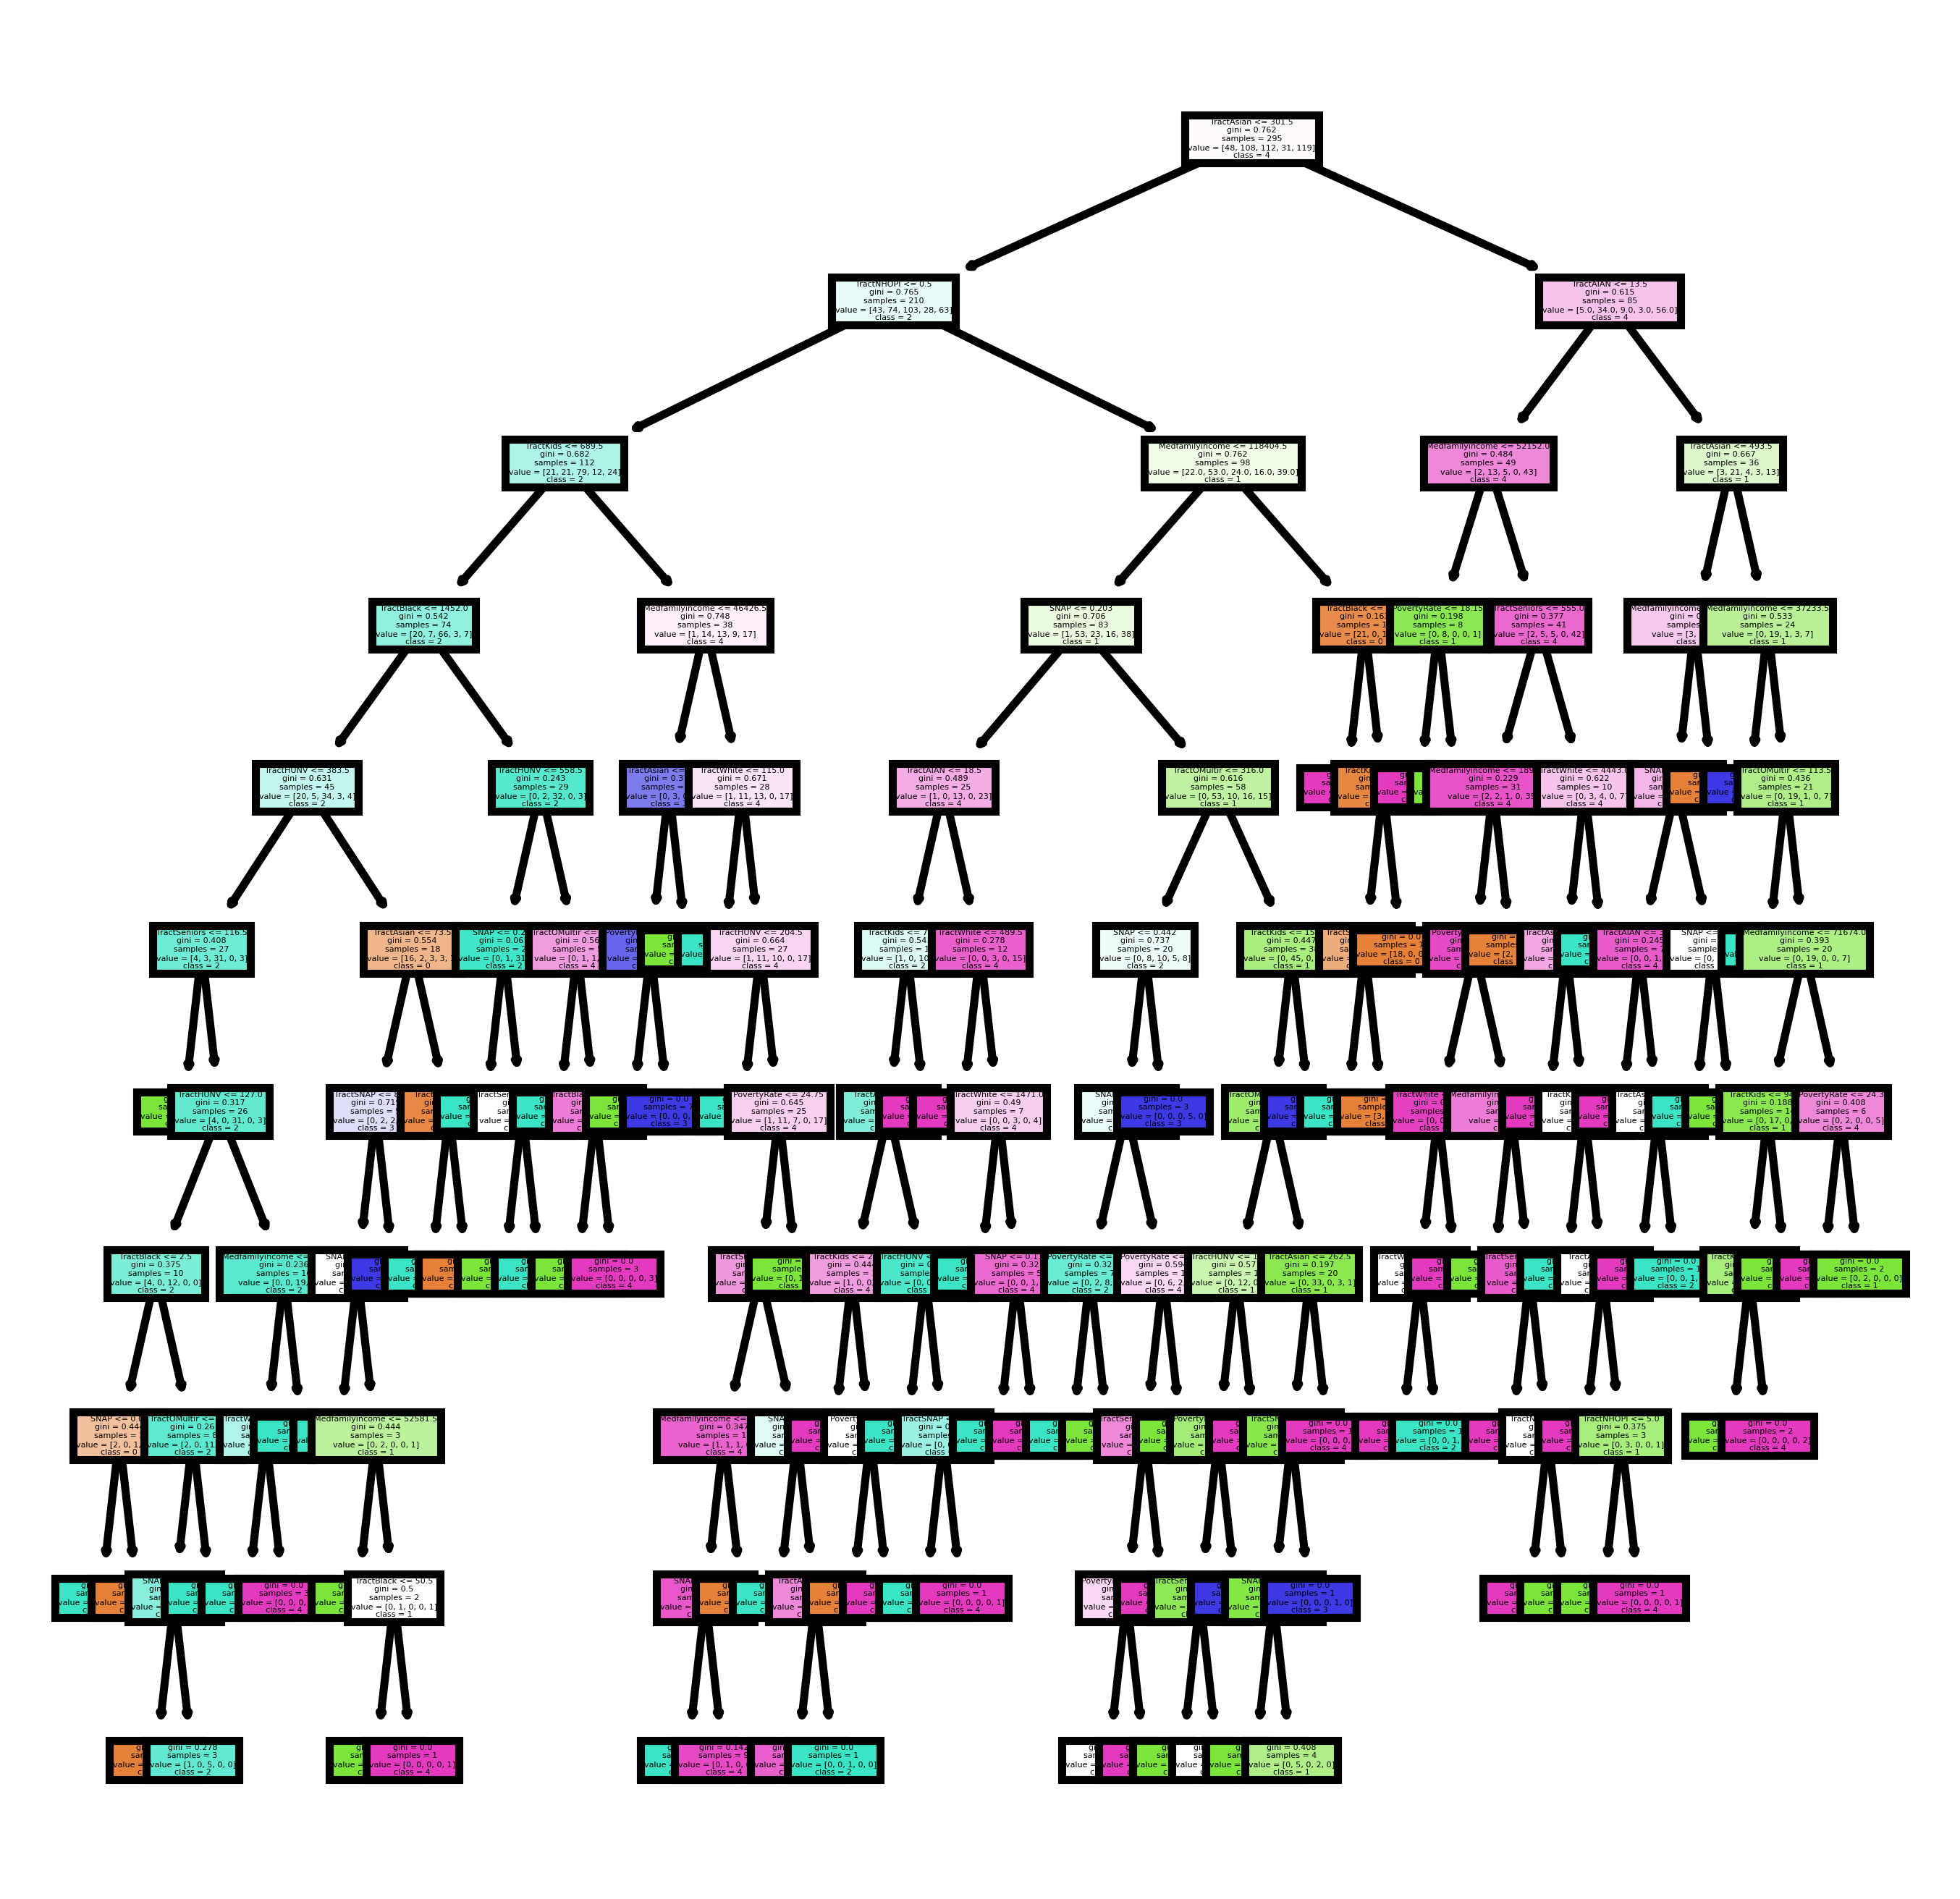

In [73]:
# Plot single decision tree from random forest 

f_names = list(X_train.columns)
c_names = ['0','1','2','3','4']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc.estimators_[0],
               feature_names = f_names, 
               class_names= c_names,
               filled = True);

fig.savefig('rf_individualtree.png')

# **Note : Since in the model training, maximum depth parameter is set as None ('max_depth=None'), 
# hence nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

## **5. Save the Trained model**

In [74]:
# Save the trained ML model 
filename = 'FoodDesert_Classification_StdzdData_Clusters_v4.pkl'
pickle.dump(rfc, open(filename, 'wb'))

In [75]:
# loading the saved model
model = pickle.load(open('FoodDesert_Classification_StdzdData_Clusters_v4.pkl', 'rb'))

## **6. Prediction**

In [82]:
X_train.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHUNV,TractSNAP
256,58919,0.182418,25.1,909,268,962,672,231,9,39,1400,643,240
442,82824,0.108193,14.0,532,317,19,2259,18,0,0,78,413,131
506,47766,0.324085,11.0,1150,419,454,3485,77,1,33,675,1366,541


In [80]:
X_test.head(3)

,Medfamilyincome,SNAP,PovertyRate,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHUNV,TractSNAP
169,99125,0.154210,19.9,586,289,347,2049,48,0,10,268,505,262
175,154250,0.082966,9.4,276,235,1945,44,147,0,8,438,753,90
253,217083,0.022678,4.6,286,170,1618,39,109,2,1,123,443,14


In [87]:
y_test.head()

169    2
175    0
253    0
440    1
624    4
Name: TargetLabel, dtype: int64

In [76]:
X_test.shape

(140, 13)

In [84]:
# predicting for random sample from train or test data (this is temporary, and will be removed before deploying the model)

sample_no = 60

predict_sample  = X_test.iloc[sample_no].to_numpy()
predict_sample

array([1.08661000e+05, 1.94407463e-01, 1.18000000e+01, 5.42000000e+02,
       3.17000000e+02, 1.90200000e+03, 8.00000000e+00, 4.80000000e+01,
       0.00000000e+00, 0.00000000e+00, 3.10000000e+01, 2.69000000e+02,
       9.50000000e+01])

In [88]:
X_test.iloc[sample_no]

Medfamilyincome    108661.000000
SNAP                    0.194407
PovertyRate            11.800000
TractKids             542.000000
TractSeniors          317.000000
TractWhite           1902.000000
TractBlack              8.000000
TractAsian             48.000000
TractNHOPI              0.000000
TractAIAN               0.000000
TractOMultir           31.000000
TractHUNV             269.000000
TractSNAP              95.000000
Name: 232, dtype: float64

In [85]:
y_test.iloc[sample_no]

2

In [86]:
input_data = predict_sample

# changing the input_data to numpy array
input_data = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data = input_data.reshape(1,-1)

print('-'*50)
predict_label = model.predict(input_data)   # prediction
print("Predicted Label : ", predict_label[0])
print("Actual Label    : ", y_test.iloc[sample_no])

print('-'*50)
if (predict_label[0] == 0):
  print('The mentioned Brooklyn area belongs to Class 0')
elif (predict_label[0] == 1):
  print('The mentioned Brooklyn area belongs to Class 1')
elif (predict_label[0] == 2):
  print('The mentioned Brooklyn area belongs to Class 2')
elif (predict_label[0] == 3):
  print('The mentioned Brooklyn area belongs to Class 3')
else :
  print('The mentioned Brooklyn area belongs to Class 4')

print('-'*50)

--------------------------------------------------
Predicted Label :  2
Actual Label    :  2
--------------------------------------------------
The mentioned Brooklyn area belongs to Class 2
--------------------------------------------------


C:\Users\Srinivas\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## **Observations**

### Iteration-1 (Target labels from clustering of **with-out** standardized data ):
* The machine learning model was performing very well with training data, but not w.r.t validation and testing data.
* The performance of the model has been not improved, even after training the model with optimized parameters obtained through hyperparameter optimization process.
* Developed a second model with transformed features, i.e., applied a log transformation to address the positive skewness present in most of the features. This steps is performed to try to convert the data to normal distribution. But this has not helped in improving the accuracy. This phenomena was expected, because tree based algorithms like Decision Tree and Random Forset performance is not affected by the distribution of the Data.
* Neural Network model also shown the similar trend w.r.t the testing dataset performance.

### Iteration-2 (Target labels from clustering of **with** standardized data ):
* The machine learning model is performing very well with training data, and performence is improved w.r.t validation and testing data (as campared to Iteration-1).

**Important points need to consider w.r.t K-Means clustering :** 
* Since K-Means algorithm uses Euclidean distance, hence it is recommended to normalize the data to ensure that all variables are on the same scale. This will help to avoid issues with variables that have different ranges.
* Since outliers can distort the cluster centroids, leading to inaccurate clustering results, hence it is important to preprocess the data and remove any outliers (need to ignore if they are actual representation of data) before applying K-Means clustering.

### **Next Step:**
* Since K-Means clustering is sensitive to the outliers, hence need to validate K-means labels with other clustering algorithms
* Update the ML model with finalized labels from clustering.